# 作业3-食物图片分类

## 项目描述
训练一个简单的卷积神经网络，实现食物图片的分类。

## 数据集介绍
本次使用的数据集为food-11数据集，共有11类

Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit.
（面包，乳制品，甜点，鸡蛋，油炸食品，肉类，面条/意大利面，米饭，海鲜，汤，蔬菜/水果）
Training set: 9866张
Validation set: 3430张
Testing set: 3347张

**数据格式**
下载 zip 档后解压缩会有三个资料夹，分别为training、validation 以及 testing
training 以及 validation 中的照片名称格式为 [类别]_[编号].jpg，例如 3_100.jpg 即为类别 3 的照片（编号不重要）

## 项目要求
* 请使用 CNN 搭建 model
* 不能使用额外 dataset
* 禁止使用 pre-trained model(只能自己手写CNN)
* 请不要上网寻找 label

## 数据准备

In [ ]:
!unzip -d work data/data57075/food-11.zip # 解压缩food-11数据集

## 环境配置/安装

无

## 作业




In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import cv2
import random
import paddle

### 观察样本

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


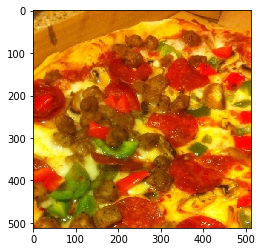

In [ ]:
img = cv2.imread('work/food-11/training/0_110.jpg')

plt.imshow(img[:,:,::-1])
plt.show()

In [ ]:
img.shape

(512, 512, 3)

由上可知输入图片为 512 * 512 的RGB图像。

### 数据读取


图像预处理：

In [ ]:
def preprocess(img,mode='train'):
    img = cv2.resize(img,(128,128))
    # 在训练集中随机对数据进行flip操作
    if mode == 'train':
        if random.randint(0,1): # 随机进行预处理
            img = cv2.flip(img,random.randint(-1,1))  # flip操作模式随机选择
    # 转换为numpy数组
    img = np.array(img).astype('float32')
    # 将数据范围改为0-1
    img = img / 255.
    # 最后更改数组的shape，使其符合CNN输入要求
    return img.transpose((2,0,1))

#### 训练集和验证集数据的导入


获得需要使用数据集文件下所有的文件名，然后在`__getitem__()`调用相应`inidex`来获得所需访问数据地址，然后读入并且进行预处理。

这里没有一并将数据读入是考虑当数据集较大的时候一并读入对内存占用比较大，故考虑先读入数据集数据的名称，在使用时在读入内存。

In [ ]:
class FoodDataSet(paddle.io.Dataset):
    def __init__(self,data_dir,mode):
        # 获取文件夹下数据名称列表
        self.filenames = os.listdir(data_dir)
        self.data_dir = data_dir
        self.mode = mode
    def __getitem__(self,index):
        file_name = self.data_dir + self.filenames[index]
        # 读取数据
        img = cv2.imread(file_name)
        # 预处理
        img = preprocess(img,mode = self.mode)
        # 获得标签
        label = int(self.filenames[index].split('_')[0]) 
        return img,label
    def __len__(self):
        return len(self.filenames)

train_dataset = FoodDataSet('work/food-11/training/','train')
train_loader = paddle.io.DataLoader(train_dataset, places=paddle.CPUPlace(), batch_size=64, shuffle=True)
# train_loader = paddle.io.DataLoader(train_dataset, places=paddle.CUDAPlace(0), batch_size=64, shuffle=True)
eval_dataset = FoodDataSet('work/food-11/validation/','validation')
eval_loader = paddle.io.DataLoader(eval_dataset, places=paddle.CPUPlace(), batch_size=64, shuffle=True)
# eval_loader = paddle.io.DataLoader(eval_dataset, places=paddle.CUDAPlace(0), batch_size=64, shuffle=True)

`FoodDataSet`类所继承的`paddle.io.Dataset`类为官方建议的数据集类型，可以直接在官方训练方法`fit()`中使用，API文档见：[`Dataset`](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/fluid/dataloader/dataset/Dataset_cn.html#dataset)。

必须要有的方法有：
- `__getitem__`: 根据给定索引获取数据集中指定样本。
- `__len__`: 返回数据集样本个数。

[`DataLoader`](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/fluid/reader/DataLoader_cn.html#dataloader)可以返回一个迭代器，其支持单进程和多进程的数据加载方式，在数据量较大的时候比较有利。

### 训练



首先定义网络结构，这里选择的`LeNet()`模型是根据[官方文档](https://www.paddlepaddle.org.cn/tutorials/projectdetail/1630501#anchor-6)很直觉写的一个模型，改变的主要是激活函数，还有将卷积的`padding`设置为`SAME`。
上面的官方文档中数据处理没有使用官方的`paddle.io.Dataset`类型，后面的训练异常繁琐，所以我将其替换掉了。

In [ ]:
class LeNet(paddle.nn.Layer):
    def __init__(self):
        super(LeNet,self).__init__()

        self.conv0 = paddle.nn.Conv2D(in_channels=3,out_channels=10,kernel_size=5,padding="SAME",stride=1)
        self.pool0 = paddle.nn.MaxPool2D(kernel_size=2,stride=2) # 128 * 128 -> 64 * 64

        self.conv1 = paddle.nn.Conv2D(in_channels=10,out_channels=20,kernel_size=5,padding="SAME",stride=1)
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2,stride=2) # 64 * 64 -> 32 * 32

        self.conv2 = paddle.nn.Conv2D(in_channels=20,out_channels=50,kernel_size=5,padding="SAME",stride=1)
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2,stride=2) # 32 * 32 -> 16 * 16

        self.fc1 = paddle.nn.Linear(in_features=12800,out_features=256)
        self.fc2 = paddle.nn.Linear(in_features=256,out_features=64)
        self.fc3 = paddle.nn.Linear(in_features=64,out_features=11)
    
    def forward(self,x):
        x = self.conv0(x)
        x = paddle.nn.functional.leaky_relu(x)
        x = self.pool0(x)

        x = self.conv1(x)
        x = paddle.nn.functional.leaky_relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = paddle.nn.functional.leaky_relu(x)
        x = self.pool2(x)

        x = paddle.reshape(x,[x.shape[0],-1])

        x = self.fc1(x)
        x = paddle.nn.functional.leaky_relu(x)
        x = self.fc2(x)
        x = paddle.nn.functional.leaky_relu(x)
        x = self.fc3(x)
        x = paddle.nn.functional.softmax(x)
        return x
network = LeNet()

上面没有使用`dropout`，当时想如果出现过拟合再使用，后来运行的时候发现有限次数内没有出现过拟合现象，所以最后也没有加。


**查看模型结构**

In [ ]:
paddle.summary(network, (1,3,128,128))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1      [[1, 3, 128, 128]]   [1, 10, 128, 128]         760      
  MaxPool2D-1   [[1, 10, 128, 128]]    [1, 10, 64, 64]           0       
   Conv2D-2      [[1, 10, 64, 64]]     [1, 20, 64, 64]         5,020     
  MaxPool2D-2    [[1, 20, 64, 64]]     [1, 20, 32, 32]           0       
   Conv2D-3      [[1, 20, 32, 32]]     [1, 50, 32, 32]        25,050     
  MaxPool2D-3    [[1, 50, 32, 32]]     [1, 50, 16, 16]           0       
   Linear-1         [[1, 12800]]           [1, 256]          3,277,056   
   Linear-2          [[1, 256]]            [1, 64]            16,448     
   Linear-3          [[1, 64]]             [1, 11]              715      
Total params: 3,325,049
Trainable params: 3,325,049
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.19
Forward/ba

{'total_params': 3325049, 'trainable_params': 3325049}

**训练模型**

LeNet()训练：

In [8]:
model = paddle.Model(network)

model.prepare(paddle.optimizer.Adam(learning_rate=0.0001, parameters=model.parameters()), 
              paddle.nn.CrossEntropyLoss(), 
              paddle.metric.Accuracy())

visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')

# 启动模型全流程训练
model.fit(train_loader,  # 训练数据集
          eval_loader,   # 评估数据集
          epochs=50,       # 训练的总轮次
          batch_size=128,  # 训练使用的批大小
          verbose=1,      # 日志展示形式
          callbacks=[visualdl])  # 设置可视化

![](https://ai-studio-static-online.cdn.bcebos.com/05ac3af0bbb849c899bdeb4068b6d6136a6f8546d6e34858bb0fe2e53b60a254)

![](https://ai-studio-static-online.cdn.bcebos.com/ec4edb7cd799498c90dabd51840480c633505c71b1cc4ec59fdc2fc7fe4344f5)


原先设置有50个epoch，但是在30个左右无论验证集还是训练集都在某一位置震荡。首先可以判断这不是过拟合，因为训练集正确率不高、训练集和验证集正确率差也不大，所以更多的可能是模型结构不合适，导致不能够拟合图片分类，或者简单地说应该是模型不够复杂或者是特征预处理不够。

因此最直接的方式就是增加卷积层，让神经网络变“深”，从而可以解决模型复杂度不够的问题。但是随着神经网络变深，也会有很多问题，这应该也是后来不再单纯增加深度的原因。如果还有时间研究一下类似于残差网络等等。


模型在验证集上进行测试：

In [9]:
model.evaluate(eval_dataset, batch_size=64, verbose=1)

Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 54/54 [==============================] - loss: 2.1489 - acc: 0.3895 - 387ms/step        
Eval samples: 3430


{'loss': [2.148915], 'acc': 0.38946433856170465}

对模型进行保存：

In [10]:
model.save('model/LeNet') 

### 模型测试

这里只是简单的将一张图片导入然后直观的测试。

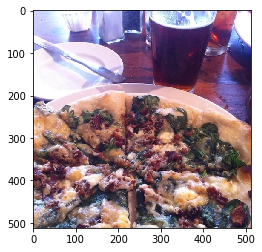

In [27]:
model_state_dict = paddle.load('model/LeNet.pdparams')
model = LeNet()
model.set_state_dict(model_state_dict)
model.eval()

text_dir = 'work/food-11/testing/'
test_filename = os.listdir(text_dir)
img = cv2.imread(text_dir + test_filename[80])

plt.imshow(img[:,:,::-1])
plt.show()

In [28]:
img = preprocess(img,mode='test')

In [29]:
res = model(paddle.to_tensor(img[np.newaxis,:,:,:]))
res

Tensor(shape=[1, 11], dtype=float32, place=CPUPlace, stop_gradient=False,
       [[0.00000001, 0.00000000, 0.25498381, 0.00000684, 0.00000000, 0.74500883, 0.00000000, 0.00000000, 0.00000000, 0.00000053, 0.00000000]])

In [30]:
np.argmax(res.numpy())

5